In [7]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from pathlib import Path

MAIN_DIR = Path(os.getcwd()).resolve().parent.parent
CHAPTER_ID = "ch_02"
GRAPH_ROOT_DIR = Path.joinpath(MAIN_DIR, "data", "graphs", CHAPTER_ID)
os.makedirs(GRAPH_ROOT_DIR, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = Path.joinpath(GRAPH_ROOT_DIR, fig_id + "." + fig_extension)
    print("Saving Figure : ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [8]:
from pathlib import Path
import os

import pandas as pd

MAIN_DIR = Path(os.getcwd()).resolve().parent.parent
DATASETS_DIR = Path.joinpath(MAIN_DIR, "data", "datasets")
HOUSING_DIR = Path.joinpath(DATASETS_DIR, "housing")
HOUSING_PATH = Path.joinpath(DATASETS_DIR, "housing", "housing.tgz")

def load_housing_data(housing_path=HOUSING_DIR):
    csv_path = Path.joinpath(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


(0.0, 16.0, 0.0, 550000.0)

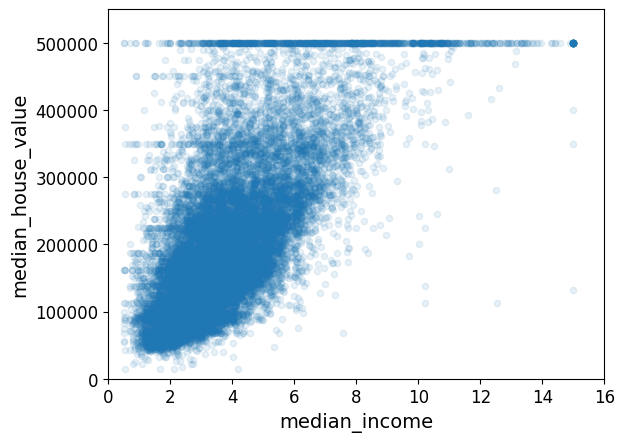

In [11]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# 계층별 랜덤 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing,  housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [14]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [15]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [18]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [20]:
X = imputer.transform(housing_num)

In [22]:
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing[["ocean_proximity"]]

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
# housing_cat_encoded[:5]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.]])

In [25]:
from sklearn.preprocessing import OneHotEncoder

# cat_encoder = OneHotEncoder()
# housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
# housing_cat_1hot.toarray()

cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
# housing_cat_1hot

/Users/kjs/miniconda3/envs/handson_ml/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [154]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없으며, 키워드 인자 활용함.
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않음
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) # 연습 용도로 방당 침실수를 추가하지 않음
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

In [156]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
1525,-122.25,38.03,15.0,3338.0,532.0,1834.0,520.0,5.6293,NEAR BAY,4,6.419231,3.526923
1407,-122.08,37.89,39.0,3018.0,501.0,1223.0,489.0,6.2924,NEAR BAY,5,6.171779,2.501022
12776,-117.1,32.71,9.0,1931.0,472.0,1628.0,445.0,2.085,NEAR OCEAN,2,4.339326,3.658427
5170,-118.31,34.19,27.0,4713.0,1169.0,2372.0,1077.0,3.7015,<1H OCEAN,3,4.376045,2.202414
7525,-118.36,33.95,26.0,3231.0,1089.0,3193.0,1020.0,2.6535,<1H OCEAN,2,3.167647,3.130392


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),    # 방당 침실수 특성도 추가. 즉, 총 3개 특성 추가됨.
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [30]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [32]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68380.70036286271

In [112]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


(0.0, 16.0, 0.0, 550000.0)

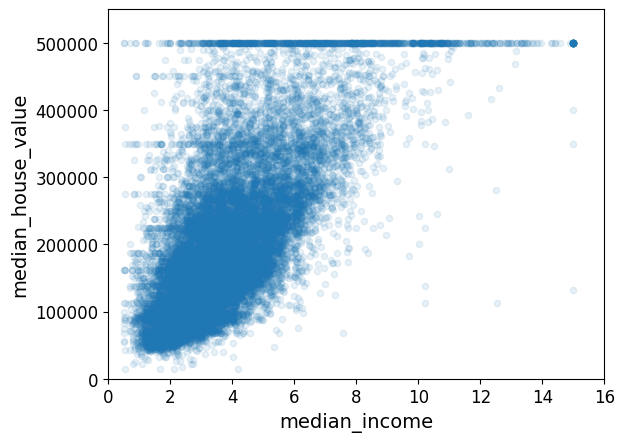

In [114]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

In [157]:
housing = load_housing_data()
print(len(housing))

housing["median_house_value"]

mhv_dic = {}
for mhv in housing["median_house_value"]:
    mhv = int(mhv)
    if mhv in mhv_dic:
        mhv_dic[mhv] += 1
    else:
        mhv_dic[mhv] = 1

print("총 가지 수 : ", len(mhv_dic))

# for v in mhv_dic:
#     if mhv_dic[v] 
#     print(mhv_dic[v])

sorted_mhv = sorted(mhv_dic.items(), key=lambda x: x[1], reverse=True)
print(sorted_mhv)


20640
총 가지 수 :  3842
[(500001, 965), (137500, 122), (162500, 117), (112500, 103), (187500, 93), (225000, 92), (350000, 79), (87500, 78), (275000, 65), (150000, 64), (175000, 63), (100000, 62), (125000, 56), (67500, 55), (250000, 47), (200000, 46), (118800, 39), (450000, 37), (156300, 35), (212500, 33), (193800, 31), (181300, 31), (75000, 30), (300000, 30), (93800, 29), (81300, 29), (55000, 29), (106300, 28), (143800, 28), (400000, 27), (500000, 27), (237500, 26), (262500, 25), (170800, 25), (166700, 23), (131300, 22), (140600, 22), (146900, 22), (90600, 22), (191700, 22), (168800, 22), (375000, 22), (325000, 22), (129200, 21), (108300, 21), (183300, 21), (158300, 21), (154200, 21), (104200, 20), (218800, 20), (166300, 20), (216700, 19), (71300, 19), (141700, 19), (206300, 19), (287500, 19), (165000, 19), (258300, 19), (179200, 18), (145800, 18), (103100, 18), (182100, 18), (95800, 18), (159400, 18), (147500, 17), (177500, 17), (243800, 17), (116700, 17), (84700, 17), (156900, 17), (153

In [158]:
for mhv in sorted_mhv[:20]:
    idx = mhv[0]
    housing.drop(housing[(housing['median_house_value'] == idx)].index, inplace=True)

In [117]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


(0.0, 16.0, 0.0, 550000.0)

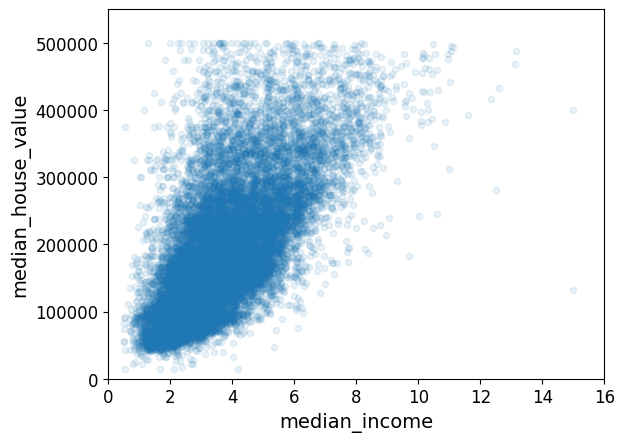

In [159]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

In [160]:
housing.reset_index(drop=True, inplace=True)

In [161]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NaN,NEAR BAY,6.984127,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NaN,NEAR BAY,6.238137,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NaN,NEAR BAY,8.288136,2.80226
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NaN,NEAR BAY,6.281853,2.181467


In [162]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


housing_num = housing.drop("ocean_proximity", axis=1)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

58351.35517545629

In [163]:
housing_chk = housing.drop("ocean_proximity", axis=1)
corr_matrix = housing_chk.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
longitude,1.000000,-0.923782,-0.098453,0.047095,0.072439,0.105264,0.058003,-0.002771,0.001159
latitude,-0.923782,1.000000,0.004351,-0.036072,-0.068428,-0.116595,-0.072556,-0.090341,-0.093014
housing_median_age,-0.098453,0.004351,1.000000,-0.387043,-0.345754,-0.314475,-0.327015,-0.207316,-0.197956
total_rooms,0.047095,-0.036072,-0.387043,1.000000,0.936768,0.865209,0.923334,0.222443,0.221981
total_bedrooms,0.072439,-0.068428,-0.345754,0.936768,1.000000,0.885846,0.980010,0.023416,0.031068
population,0.105264,-0.116595,-0.314475,0.865209,0.885846,1.000000,0.914664,0.040544,0.046461
households,0.058003,-0.072556,-0.327015,0.923334,0.980010,0.914664,1.000000,0.046529,0.054469
median_income,-0.002771,-0.090341,-0.207316,0.222443,0.023416,0.040544,0.046529,1.000000,0.942997
income_cat,0.001159,-0.093014,-0.197956,0.221981,0.031068,0.046461,0.054469,0.942997,1.000000
